# 2. 彩色图像修复

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
from ipywidgets import interact
import matplotlib
########################################################修复###########################################
def BSCB_Inpainting(img,dt,Mask,RGB):
    I = img.copy()
    shape = img.shape
    m = shape[0]
    n = shape[1]
    if RGB:
        for channel in range(3):
            Ixh = np.vstack((I[0,:,channel],I[0:m-1,:,channel]))
            Ixq = np.vstack((I[1:m,:,channel],I[m-1,:,channel]))
            Iyh = np.hstack((I[:,0:1,channel],I[:,0:n-1,channel]))
            Iyq = np.hstack((I[:,1:n,channel],I[:,n-1:n,channel]))

            Ix = (Ixq-Ixh)/2
            Iy = (Iyq-Iyh)/2
            Ixx = Ixq+Ixh - 2*I[:,:,channel]
            Iyy = Iyq+Iyh - 2*I[:,:,channel]
            Laplace = Ixx+Iyy
            Laplacex = (np.vstack((Laplace[1:m,:],Laplace[m-1:m,:]))-np.vstack((Laplace[0:1,:],Laplace[0:m-1,:])))/2
            Laplacey = (np.hstack((Laplace[:,1:n],Laplace[:,n-1:n]))-np.hstack((Laplace[:,0:1],Laplace[:,0:n-1])))/2
            Temp = np.sqrt(Ix**2+Iy**2+0.0001)
            normNx = -Iy/Temp
            normNy = Ix/Temp
            Beta = Laplacex*normNx+Laplacey*normNy
            Ixhm = np.minimum(I[:,:,channel]-Ixh,0)
            Iyhm = np.minimum(I[:,:,channel]-Iyh,0)
            Ixqm = np.minimum(Ixq-I[:,:,channel],0)
            Iyqm = np.minimum(Iyq-I[:,:,channel],0)
            IxhM = np.maximum(I[:,:,channel]-Ixh,0)
            IyhM = np.maximum(I[:,:,channel]-Iyh,0)
            IxqM = np.maximum(Ixq-I[:,:,channel],0)
            IyqM = np.maximum(Iyq-I[:,:,channel],0)
            MuD1 = np.sqrt(Ixhm**2 + IxqM**2 + Iyhm**2 + IyqM**2)
            MuD2 = np.sqrt(IxhM**2 + Ixqm**2 + IyhM**2 + Iyqm**2)
            MuD =  Beta*((Beta>0)*MuD1 +(1-(Beta>0))*MuD2)
            signMuD = np.sign(MuD)
            I[:,:,channel] = I[:,:,channel]+dt*Mask*signMuD*np.sqrt(np.sqrt(signMuD*MuD))
#             I[:,:,channel] = I[:,:,channel]+dt*signMuD*np.sqrt(np.sqrt(signMuD*MuD))
#             I[:,:,channel] = I[:,:,channel]+dt*Mask*MuD
    else:
        Ixh = np.vstack((I[0,:],I[0:m-1,:]))
        Ixq = np.vstack((I[1:m,:],I[m-1,:]))
        Iyh = np.hstack((I[:,0:1],I[:,0:n-1]))
        Iyq = np.hstack((I[:,1:n],I[:,n-1:n]))

        Ix = (Ixq-Ixh)/2
        Iy = (Iyq-Iyh)/2
        Ixx = Ixq+Ixh - 2*I
        Iyy = Iyq+Iyh - 2*I
        Laplace = Ixx+Iyy
        Laplacex = (np.vstack((Laplace[1:m,:],Laplace[m-1:m,:]))-np.vstack((Laplace[0:1,:],Laplace[0:m-1,:])))/2
        Laplacey = (np.hstack((Laplace[:,1:n],Laplace[:,n-1:n]))-np.hstack((Laplace[:,0:1],Laplace[:,0:n-1])))/2
        Temp = np.sqrt(Ix**2+Iy**2+0.0001)
        normNx = -Iy/Temp
        normNy = Ix/Temp
        Beta = Laplacex*normNx+Laplacey*normNy
        Ixhm = np.minimum(I-Ixh,0)
        Iyhm = np.minimum(I-Iyh,0)
        Ixqm = np.minimum(Ixq-I,0)
        Iyqm = np.minimum(Iyq-I,0)
        IxhM = np.maximum(I-Ixh,0)
        IyhM = np.maximum(I-Iyh,0)
        IxqM = np.maximum(Ixq-I,0)
        IyqM = np.maximum(Iyq-I,0)
        MuD1 = np.sqrt(Ixhm**2 + IxqM**2 + Iyhm**2 + IyqM**2)
        MuD2 = np.sqrt(IxhM**2 + Ixqm**2 + IyhM**2 + Iyqm**2)
        MuD =  Beta*((Beta>0)*MuD1 +(1-(Beta>0))*MuD2)
        signMuD = np.sign(MuD)
        I = I+dt*Mask*signMuD*np.sqrt(np.sqrt(signMuD*MuD))
#     I = I + dt*Mask*MuD
    return I



In [2]:
#######################################################扩散###########################################
def BSCB_Diffusion(img,dt,Mask,RGB):
    I = img.copy()
    shape = img.shape
#     print(shape)
    m = shape[0]
    n = shape[1]
    if RGB:
        for channel in range(3):
            Ixh = np.vstack((I[0:1,:,channel],I[0:m-1,:,channel]))
            Ixq = np.vstack((I[1:m,:,channel],I[m-1:m,:,channel]))
            Iyh = np.hstack((I[:,0:1,channel],I[:,0:n-1,channel]))
            Iyq = np.hstack((I[:,1:n,channel],I[:,n-1:n,channel]))
            Ixqyq = np.hstack((Ixq[:,1:n],Ixq[:,n-1:n]))
            Ixhyq = np.hstack((Ixh[:,1:n],Ixh[:,n-1:n]))
            Ixqyh = np.hstack((Ixq[:,0:1],Ixq[:,0:n-1]))
            Ixhyh = np.hstack((Ixh[:,0:1],Ixh[:,0:n-1]))
            Ix = (Ixq-Ixh)/2
            Iy = (Iyq-Iyh)/2
            Ixx = Ixq+Ixh - 2*I[:,:,channel]
            Iyy = Iyq+Iyh - 2*I[:,:,channel]
            Ixy = ((Ixqyq + Ixhyq)/2 - (Ixqyh+Ixhyh)/2)/2
            TempNorm = Ix**2+Iy**2+0.0001
            DMu = (Ixx*(Iy**2)+Iyy*(Ix**2)-2*Ix*Iy*Ixy)/TempNorm
            I[:,:,channel] = I[:,:,channel] + dt*Mask*DMu
    else:
        Ixh = np.vstack((I[0:1,:],I[0:m-1,:]))
        Ixq = np.vstack((I[1:m,:],I[m-1:m,:]))
        Iyh = np.hstack((I[:,0:1],I[:,0:n-1]))
        Iyq = np.hstack((I[:,1:n],I[:,n-1:n]))
        Ixqyq = np.hstack((Ixq[:,1:n],Ixq[:,n-1:n]))
        Ixhyq = np.hstack((Ixh[:,1:n],Ixh[:,n-1:n]))
        Ixqyh = np.hstack((Ixq[:,0:1],Ixq[:,0:n-1]))
        Ixhyh = np.hstack((Ixh[:,0:1],Ixh[:,0:n-1]))
        Ix = (Ixq-Ixh)/2
        Iy = (Iyq-Iyh)/2
        Ixx = Ixq+Ixh - 2*I
        Iyy = Iyq+Iyh - 2*I
        Ixy = ((Ixqyq + Ixhyq)/2 - (Ixqyh+Ixhyh)/2)/2
        TempNorm = Ix**2+Iy**2+0.0001
        DMu = (Ixx*(Iy**2)+Iyy*(Ix**2)-2*Ix*Iy*Ixy)/TempNorm
        I = I + dt*Mask*DMu
    return I        
#######################################################相关随机初始化###########################################
def Initial(img,Mask,RGB):
    I = img.copy()
    shape = img.shape
    m = shape[0]
    n = shape[1]
    if RGB==True:
        print("dws")
        for channel in range(3):
            for i in range(m):
                for j in range(n):
                    if Mask[i,j] == 1:
                        T = i
                        while Mask[i,j] == 1:
                            if i<1: break
                            i = i-1
                        k1 = i
                        i = T
                        while Mask[i,j] == 1:
                            if i>m-2: break
                            i = i+1
                        k2 = i
                        i = T
                        T = j
                        while Mask[i,j] == 1:
                            if j<1: break
                            j = j-1
                        k3 = j
                        j = T
                        while Mask[i,j] == 1:
                            if j>n-2: break
                            j = j+1
                        k4 = j
                        j = T

                        if (k2-k1)>(k4-k3):
                            rand1 = int(I[i,k3,channel])
                            rand2 = int(I[i,k4,channel])
                            minr = np.min([rand1+1,rand2-1])
                            maxr = np.max([rand1+1,rand2-1])
                            trand = np.random.randint(minr, maxr+1)
                            I[i,j,channel] = np.uint8(trand)
                        elif (k2-k1)<(k4-k3):
                            rand1 = int(I[k1,j,channel])
                            rand2 = int(I[k2,j,channel])
                            minr = np.min([rand1+1,rand2-1])
                            maxr = np.max([rand1+1,rand2-1])
                            trand = np.random.randint(minr, maxr+1)
                            I[i,j,channel] =  np.uint8(trand)
                        else:
                            rand1 = int(I[i,k3,channel])
                            rand2 = int(I[i,k4,channel])
                            minr = np.min([rand1+1,rand2-1])
                            maxr = np.max([rand1+1,rand2-1])
                            trand1 = np.random.randint(minr, maxr+1)
                            rand1 = int(I[k1,j,channel])
                            rand2 = int(I[k2,j,channel])
                            minr = np.min([rand1+1,rand2-1])
                            maxr = np.max([rand1+1,rand2-1])
                            trand2 = np.random.randint(minr, maxr+1)
                            I[i,j,channel] =  np.uint8((trand1+trand2)/2)
    else:
            for i in range(m):
                for j in range(n):
                    if Mask[i,j] == 1:
                        T = i
                        while Mask[i,j] == 1:
                            if i<1: break
                            i = i-1
                        k1 = i
                        i = T
                        while Mask[i,j] == 1:
                            if i>m-2: break
                            i = i+1
                        k2 = i
                        i = T
                        T = j
                        while Mask[i,j] == 1:
                            if j<1: break
                            j = j-1
                        k3 = j
                        j = T
                        while Mask[i,j] == 1:
                            if j>n-2: break
                            j = j+1
                        k4 = j
                        j = T

                        if (k2-k1)>(k4-k3):
                            rand1 = int(img[i,k3])
                            rand2 = int(img[i,k4])
                            minr = np.min([rand1+1,rand2-1])
                            maxr = np.max([rand1+1,rand2-1])
                            trand = np.random.randint(minr, maxr+1)
                            I[i,j] = np.uint8(trand)
                        elif (k2-k1)<(k4-k3):
                            rand1 = int(img[k1,j])
                            rand2 = int(img[k2,j])
                            minr = np.min([rand1+1,rand2-1])
                            maxr = np.max([rand1+1,rand2-1])
                            trand = np.random.randint(minr, maxr+1)
                            I[i,j] =  np.uint8(trand)
                        else:
                            rand1 = int(img[i,k3])
                            rand2 = int(img[i,k4])
                            minr = np.min([rand1+1,rand2-1])
                            maxr = np.max([rand1+1,rand2-1])
                            trand1 = np.random.randint(minr, maxr+1)
                            rand1 = int(img[k1,j])
                            rand2 = int(img[k2,j])
                            minr = np.min([rand1+1,rand2-1])
                            maxr = np.max([rand1+1,rand2-1])
                            trand2 = np.random.randint(minr, maxr+1)
                            I[i,j] =  np.uint8((trand1+trand2)/2)
    return I


def mse(img1,img2,m,n):
    delta = img1-img2
    sumd = np.sum(delta*delta)
    return sumd/(m*n)

In [3]:
##################################################################################################
ix,iy=-1,-1
t0 = 0
point_num = 0
def draw_circle(event,x,y,flags,param):
    global t0, point_num,ix,iy
    if (event == cv.EVENT_MOUSEMOVE) and (flags == cv.EVENT_FLAG_LBUTTON):
        t1 = time.perf_counter()
        duration = t1 - t0
        if duration > 0.2:
            point_num = 0
        if point_num != 0:
            cv.circle(param[0],(x,y),4,(0,0,255),-1)
            cv.circle(param[1],(x,y),4,255,-1)
            cv.line(param[0],(ix,iy),(x,y),(0,0,255),4)
            cv.line(param[1],(ix,iy),(x,y),255,4)

        else:
            cv.circle(param[0],(x,y),4,(0,0,255),-1)
            cv.circle(param[1],(x,y),4,255,-1)
        ix = x
        iy = y
        t0 = t1
        point_num = point_num + 1

def output_mask(img0):
    img = img0.copy()
    height = img.shape[0]
    width = img.shape[1]
    mask = np.zeros((height,width,1),np.uint8)
    cv.namedWindow('image')
    global t0
    t0 = time.perf_counter()
    cv.setMouseCallback('image',draw_circle,[img, mask])
    while(1):
        cv.imshow('image',img)
        k=cv.waitKey(1)
        if k==ord('q'):
            cv.destroyWindow('image')
            break
    return mask
###########################################自动获取掩模################################
def mask_old(string):
    mask = cv.imread(string)
    MA = cv.cvtColor(mask,cv.COLOR_BGR2GRAY)
    shape = MA.shape
    m = shape[0]
    n = shape[1]
    MM = np.zeros((shape))
    for i in range(m):
        for j in range(n):
            if MA[i,j] == 0:
                MM[i,j] = 0
            else:
                MM[i,j] = 1
    return MM,MA

Text(0.5, 1.0, 'MASK')

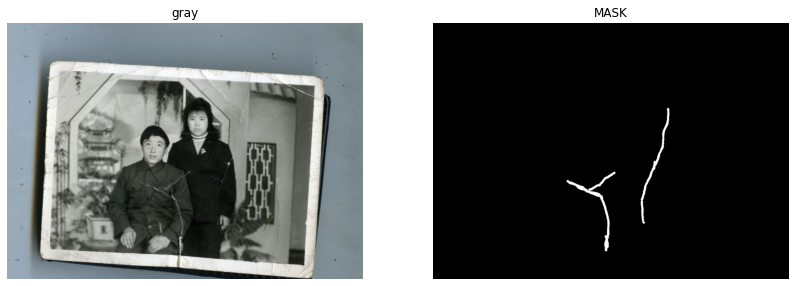

In [4]:

grayimgA = cv.imread('564.jpg')
grayimgA = grayimgA[:,:,::-1]
shape = grayimgA.shape
m = shape[0]
n = shape[1]
###############################################手动获取掩模################################
mask1 = output_mask(grayimgA)
#grayimgA = cv.cvtColor(imgA,cv.COLOR_RGB2GRAY)
FlagColor = 1;

mask0 = np.zeros((m,n),np.uint8)
mask0 = mask1[:,:,0]
M = mask0/255
###########################################自动获取掩模################################
# M,mask0 = mask_old('Peppers_mask.bmp')

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(grayimgA)
plt.axis("off")
plt.title("gray")

plt.subplot(122)
plt.imshow(mask0,cmap="gray")
plt.axis("off")
plt.title("MASK")

In [ ]:
time1 = time.time()
J = Initial(grayimgA,M,True)
Jinitial = J
J = np.double(J)
maxiter = 2000
imgB = BSCB_Diffusion(J,0.1,M,True)
for k in range(maxiter):
    J0 = J
    J = BSCB_Inpainting(J,0.1,M,True)
    if k%25 == 0:
        J = BSCB_Diffusion(J,0.1,M,True)
    if(255*mse(J,J0,m,n))<0.1:     #阈值判断
        break
time2 = time.time()

dws


In [ ]:

J = np.uint8(J)
plt.figure(figsize=(14,8))
plt.subplot(131)
plt.imshow(grayimgA)
plt.axis("off")
plt.title("RGB")

plt.subplot(132)
plt.imshow(Jinitial)
plt.axis("off")
plt.title("Initial")

plt.subplot(133)
plt.imshow(J)
plt.axis("off")
plt.title("BSCB")
plt.tight_layout()

In [ ]:
print('循环次数',k+1)
print('运行时间',"%.3f"%(time2-time1),'S')
import math
def PSNR(img1, img2):
    mse = np.mean( (img1/255. - img2/255.) ** 2 )
    if mse < 1.0e-10:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

print('峰值信噪比:',"%.3f"%PSNR(grayimgA, J),'dB')